# Test decoupled plane-based registration

In [1]:
%matplotlib widget
import numpy as np
import os

import planeslam.io as io
from planeslam.general import plot_3D_setup, color_legend
from planeslam.scan import pc_to_scan
from planeslam.registration import extract_corresponding_features, get_correspondences
from planeslam.geometry.util import quat_to_rot_mat

%load_ext autoreload
%autoreload 2

### Test with two planes

In [2]:
from planeslam.geometry.plane import BoundedPlane
from planeslam.registration import expmap
from planeslam.scan import Scan
import copy

V1 = np.array([[-1, 1, -1],
              [1, 1, -1],
              [1, 1, 1],
              [-1, 1, 1]])
V2 = np.array([[-1, -1, -1],
              [-1, 1, -1],
              [-1, 1, 1],
              [-1, -1, 1]])
P = Scan([BoundedPlane(V1), BoundedPlane(V2)])

# Ground-truth transformation
t = np.array([0, -0.5, 0])[:,None]
u = np.array([0, 1, 0])[:,None]
theta = np.pi/12
q = np.vstack((t, theta*u))

R = expmap(q[3:].flatten())

print("t: ", t)
print("R: ", R)

vertex and face generation not yet implemented
t:  [[ 0. ]
 [-0.5]
 [ 0. ]]
R:  [[ 0.96592583  0.          0.25881905]
 [ 0.          1.          0.        ]
 [-0.25881905  0.          0.96592583]]


In [3]:
# P is source, Q is target
Q = copy.deepcopy(P)
Q.transform(R, t.flatten())

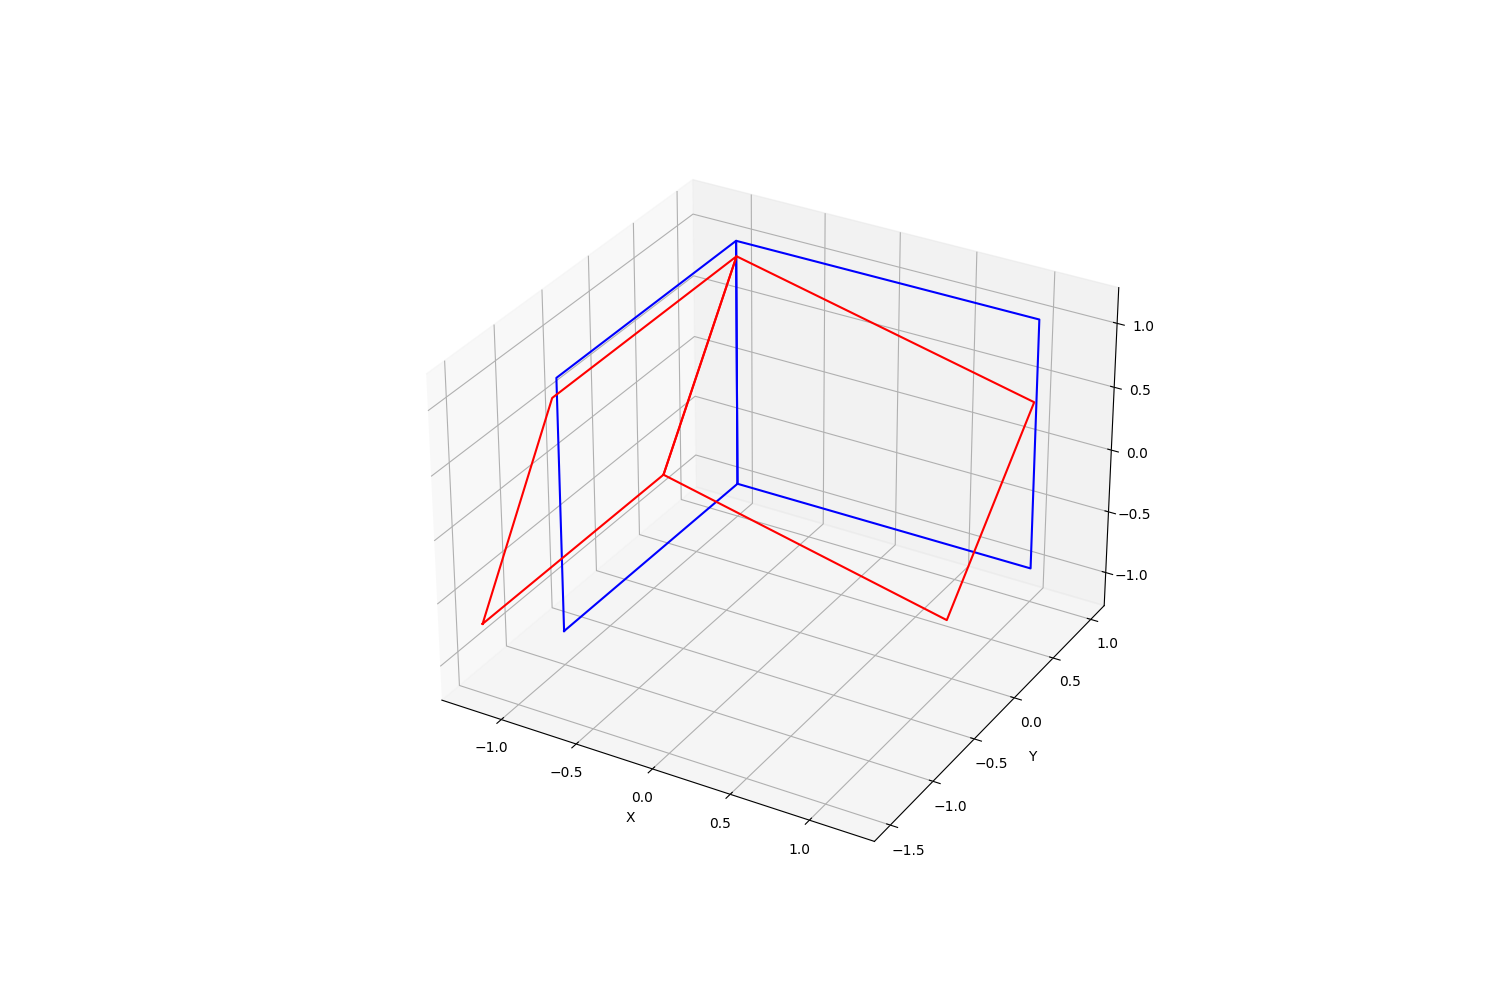

In [4]:
ax = plot_3D_setup()
P.plot(ax, color='b')
Q.plot(ax, color='r')

In [5]:
correspondences = [(0,0), (1,1)]
n_s, d_s, n_t, d_t = extract_corresponding_features(P, Q, correspondences)

Estimate rotation

In [10]:
H = n_s[:3] @ n_t[:3].T + n_s[3:] @ n_t[3:].T
u, s, v = np.linalg.svd(H)
R_hat = u @ v

Estimate translation

In [27]:
A = np.reshape(n_t, (-1,3))
b = d_t - d_s
t_hat = np.linalg.lstsq(A, b, rcond=None)[0]

### Test on airsim scans

Read in airsim LiDAR data and poses

In [2]:
# Read in point cloud data
binpath = os.path.join(os.getcwd(), '..', '..', 'data', 'airsim', 'blocks_20_samples_1', 'lidar', 'Drone0')
PC_data = io.read_lidar_bin(binpath)

# Read in ground-truth poses (in drone local frame)
posepath = os.path.join(os.getcwd(), '..', '..', 'data', 'airsim', 'blocks_20_samples_1', 'poses', 'Drone0')
drone_positions, drone_orientations = io.read_poses(posepath)

Extract planes

In [3]:
num_scans = len(PC_data)
scans = num_scans * [None]
scans_transformed = num_scans * [None]
for i in range(num_scans):
    scans[i] = pc_to_scan(PC_data[i])

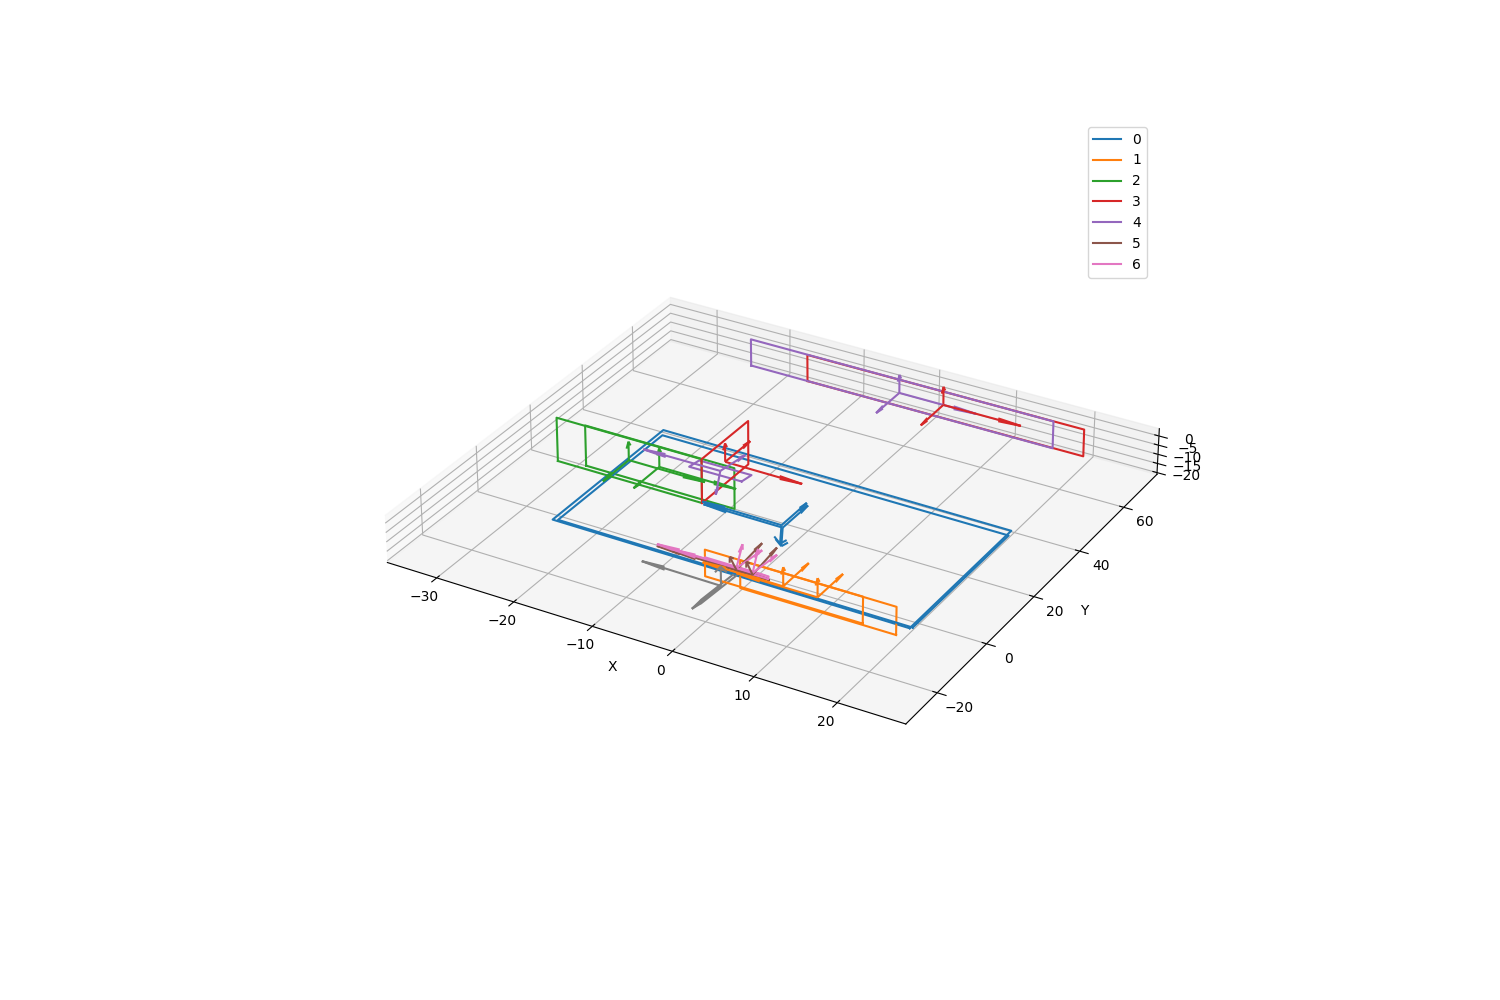

In [14]:
idx_1 = 5
idx_2 = 6

# Plot first 2 scans
ax = plot_3D_setup(PC_data[0])

scans[idx_1].plot(ax, show_normals=True)
scans[idx_2].plot(ax, show_normals=True)

# Color legend
num_colors = max([len(s.planes) for s in scans[0:2]])
color_legend(ax, num_colors)

In [15]:
# Ground-truth answer
t_gt = drone_positions[idx_2] - drone_positions[idx_1]
R_0 = quat_to_rot_mat(drone_orientations[idx_1])
R_1 = quat_to_rot_mat(drone_orientations[idx_2])
R_gt = np.linalg.inv(R_0) @ R_1

print(f't_gt: {t_gt} \n R_gt: {R_gt}')

t_gt: [ 4.43161011e+00 -3.46274192e-08  2.31816769e-02] 
 R_gt: [[ 9.99997729e-01  1.11777989e-09  2.13131647e-03]
 [-1.20864061e-09  1.00000000e+00  4.26299792e-08]
 [-2.13131647e-03 -4.26324584e-08  9.99997729e-01]]


In [16]:
# Extract normals and distances
# Use scans[0] as source and scans[1] as target
correspondences = get_correspondences(scans[idx_2], scans[idx_1])
#correspondences = [(0,0), (1,1), (2,2), (3,3), (4,5)]
n_s, d_s, n_t, d_t = extract_corresponding_features(scans[idx_2], scans[idx_1], correspondences)

Rotation estimation

In [17]:
H = np.zeros((3,3))
for i in range(len(correspondences)):
    H += n_s[3*i:3*(i+1)] @ n_t[3*i:3*(i+1)].T

In [18]:
u, s, v = np.linalg.svd(H)
R_hat = u @ v
print(R_hat)

[[-9.99489781e-01 -3.21358961e-03  3.17781333e-02]
 [-3.21818521e-03  9.99994817e-01 -9.34692132e-05]
 [ 3.17776682e-02  1.95689442e-04  9.99494943e-01]]


Translation estimation

In [19]:
A = np.reshape(n_t, (-1,3))
b = d_t - d_s
t_hat = np.linalg.lstsq(A, b, rcond=None)[0]
print(t_hat)

[[ 2.30098658]
 [-0.00383921]
 [-0.02968871]]


Plot the result

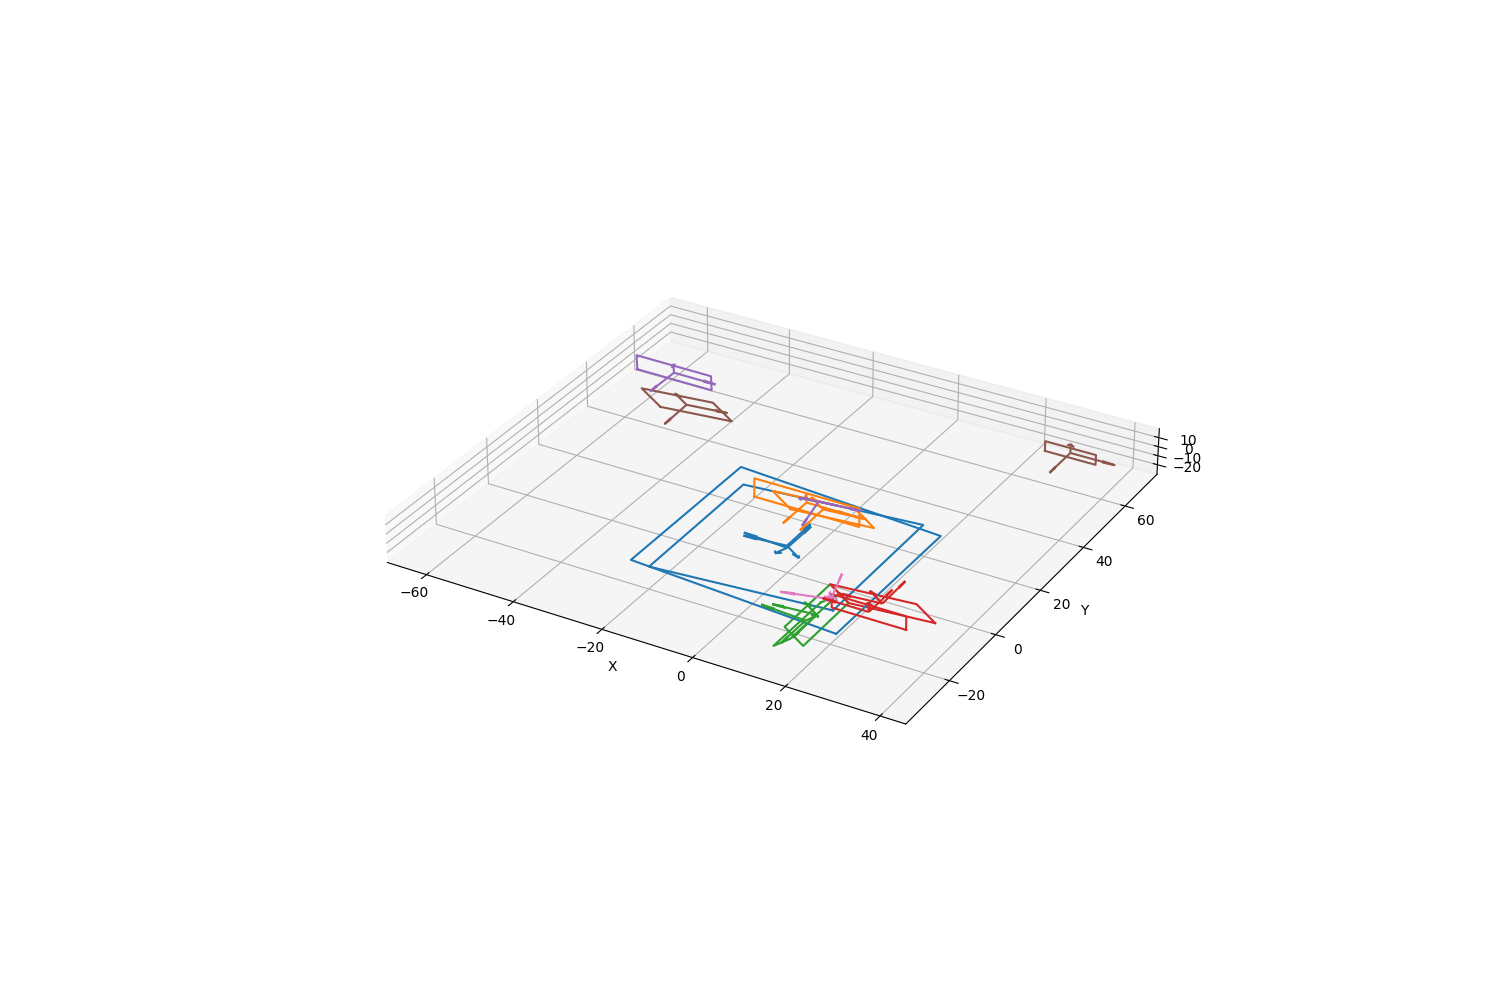

In [58]:
source_transformed = scans[0]
source_transformed.transform(R_hat, t_hat.flatten())
target = scans[1]

ax = plot_3D_setup(PC_data[0])

source_transformed.plot(ax, show_normals=True)
target.plot(ax, show_normals=True)


Run on whole trajectory

In [26]:
from planeslam.registration import decoupled_register
from planeslam.registration import GN_register
import time

abs_traj_transformations = np.zeros((num_scans-1,4,4))
T_abs = np.eye(4)
avg_runtime = 0

for i in range(len(scans)-1):
    start_time = time.time()
    R_hat, t_hat = GN_register(scans[i+1], scans[i])
    avg_runtime += time.time() - start_time
    print(t_hat)
    T_hat = np.vstack((np.hstack((R_hat, t_hat)), np.hstack((np.zeros(3), 1))))
    T_abs = T_hat @ T_abs
    abs_traj_transformations[i,:,:] = T_abs

avg_runtime /= len(scans)-1
print("average registration time: ", avg_runtime)

[[30.65781316]
 [11.14045757]
 [24.75049125]]
[[-2.30432372]
 [ 0.41884598]
 [ 2.66917582]]
[[21.72484633]
 [-0.09876678]
 [-1.91956773]]
[[ 1.15165551]
 [-1.21816989]
 [-0.69710301]]
[[ 4.46552276]
 [-2.58861795]
 [ 0.43554267]]
[[ 2.57591884]
 [-1.27890639]
 [ 1.22939859]]
[[ 1.01337052]
 [ 4.24488642]
 [-1.43561391]]
[[ 3.33569991]
 [ 2.45866558]
 [-0.06655443]]
[[ 1.66253919]
 [ 0.6455487 ]
 [-0.33395277]]
[[0.37064758]
 [2.63345334]
 [0.30168026]]
[[0.37951396]
 [2.22646193]
 [1.73592929]]
[[-30.67015886]
 [  2.12155472]
 [ 14.3049225 ]]
[[8.69197295]
 [0.06868411]
 [2.63284572]]
[[8.61138633]
 [0.45126762]
 [6.60660177]]
[[0.59507523]
 [1.97110034]
 [0.14642334]]
[[0.45874694]
 [1.2864742 ]
 [2.1262965 ]]
[[-0.97621036]
 [ 0.07816455]
 [ 0.05089134]]
[[0.16688146]
 [0.0009609 ]
 [0.02947214]]
[[-0.03333937]
 [ 0.21852243]
 [ 1.64766113]]
average registration time:  0.0013161082016794306


In [27]:
np.set_printoptions(suppress=True)
np.round(abs_traj_transformations[:,:3,3],2)

array([[ 30.66,  11.14,  24.75],
       [ 37.83,   7.71,   6.2 ],
       [ 59.55,   9.41,   0.89],
       [-11.55,  52.9 ,  22.66],
       [ 31.95,   5.27,  51.7 ],
       [ 20.41, -45.41,  39.39],
       [-60.26,   0.1 ,  14.64],
       [ 15.45, -56.72, -14.11],
       [ 21.76, -45.79, -33.41],
       [-45.95,  34.19, -23.06],
       [ 42.39, -37.83, -19.29],
       [-82.89,  -5.25, -14.31],
       [ 24.28, -14.35, -78.93],
       [ 58.67,  22.76, -56.81],
       [ 37.8 , -45.29, -59.61],
       [ 46.7 , -38.82,  59.45],
       [ 51.69,  -3.  ,  66.68],
       [ 48.65,  -6.  ,  68.88],
       [ -6.49, -30.97,  79.96]])

In [28]:
np.save("l2l_abs_traj_transformations", np.array(abs_traj_transformations))